<a href="https://colab.research.google.com/github/amshah1022/mech-interp-mini/blob/main/mech_interp_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformer-lens==1.15 einops torch --quiet
from transformer_lens import HookedTransformer
import torch, numpy as np, matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_grad_enabled(False)
model = HookedTransformer.from_pretrained("gpt2-small", device=device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer


In [30]:
def first_subtoken_id(token_str: str) -> int:
    ids = model.to_tokens(token_str, prepend_bos=False)[0]
    return int(ids[0].item())

def logit_lens_curve(prompt: str, target_token: str):
    toks = model.to_tokens(prompt, prepend_bos=True).to(device)
    # Cache the residual streams we need
    _, cache = model.run_with_cache(
        toks,
        names_filter=lambda n: ("hook_resid_pre" in n) or ("hook_resid_post" in n) or ("ln_final" in n)
    )
    tgt_id = first_subtoken_id(target_token)

    # discover layers that actually exist
    layers = sorted({int(k.split(".")[1]) for k in cache.keys() if k.endswith(".hook_resid_pre")})

    vals = []
    for L in layers:
        # KEEP 3D SHAPE: [1, 1, d_model]
        resid_last = cache[f"blocks.{L}.hook_resid_pre"][:, -1:, :]          # [1,1,d_model]
        logits = model.unembed(model.ln_final(resid_last))                   # [1,1,vocab]
        vals.append(float(logits[0, 0, tgt_id].item()))

    # final point from last block’s resid_post (if present)
    last_key = f"blocks.{layers[-1]}.hook_resid_post"
    if last_key in cache:
        resid_final = cache[last_key][:, -1:, :]                             # [1,1,d_model]
        logits_final = model.unembed(model.ln_final(resid_final))            # [1,1,vocab]
        vals.append(float(logits_final[0, 0, tgt_id].item()))

    return vals



In [36]:
qa = [
    {"q": "Who wrote Pride and Prejudice?", "a0": " Jane"},
    {"q": "Who wrote Emma?", "a0": " Jane"},
    {"q": "Who wrote Jane Eyre?", "a0": " Charlotte"},
    {"q": "What is the capital of France?", "a0": " Paris"},
    {"q": "What is 2+2?", "a0": " 4"},
]



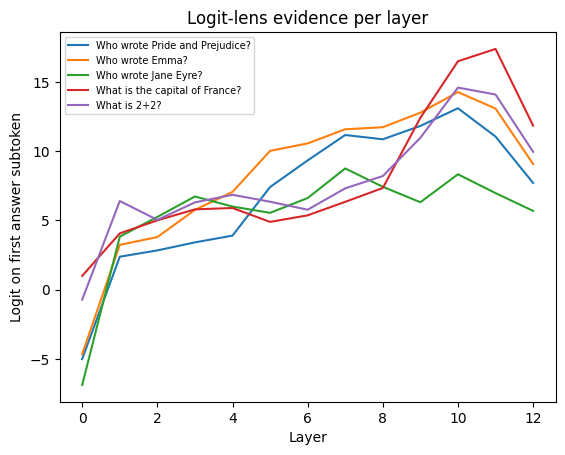

In [37]:
for item in qa:
    plt.plot(logit_lens_curve(item["q"], item["a0"]), label=item["q"])
plt.xlabel("Layer"); plt.ylabel("Logit on first answer subtoken")
plt.title("Logit-lens evidence per layer"); plt.legend(fontsize=7); plt.show()


In [38]:
def causal_head_scores(clean_prompt: str, corrupt_prompt: str, ans_token: str):
    t_clean = model.to_tokens(clean_prompt, prepend_bos=True).to(device)
    t_corr  = model.to_tokens(corrupt_prompt, prepend_bos=True).to(device)

    # cache from the CLEAN run (we’ll copy from this)
    _, cache_clean = model.run_with_cache(
        t_clean,
        names_filter=lambda n: ("attn.hook_z" in n)
    )

    ans_id = first_subtoken_id(ans_token)
    with torch.no_grad():
        base = model(t_corr)[0, -1, ans_id].item()

    scores = np.zeros((model.cfg.n_layers, model.cfg.n_heads))

    def patch_hook_factory(L, H):
        def hook(z, hook):  # z: [B, seq, n_heads, d_head]
            z[:, -1, H, :] = cache_clean[hook.name][:, -1, H, :]
            return z
        return hook

    for L in range(model.cfg.n_layers):
        for H in range(model.cfg.n_heads):
            with torch.no_grad():
                logits = model.run_with_hooks(
                    t_corr,
                    fwd_hooks=[(f"blocks.{L}.attn.hook_z", patch_hook_factory(L, H))]
                )
                scores[L, H] = logits[0, -1, ans_id].item() - base
    return scores


In [39]:
clean = "Who wrote Pride and Prejudice?"
corrupt = "Who wrote Pride and Prejudice? Some say Emily Brontë."
scores = causal_head_scores(clean, corrupt, " Jane")
flat = [((L,H), scores[L,H]) for L in range(model.cfg.n_layers) for H in range(model.cfg.n_heads)]
top = sorted(flat, key=lambda x: x[1], reverse=True)[:10]
top


[((9, 7), np.float64(0.9495429992675781)),
 ((6, 3), np.float64(0.36739540100097656)),
 ((8, 8), np.float64(0.33812713623046875)),
 ((0, 8), np.float64(0.27104759216308594)),
 ((8, 10), np.float64(0.2702512741088867)),
 ((6, 1), np.float64(0.2625398635864258)),
 ((7, 6), np.float64(0.23040390014648438)),
 ((8, 6), np.float64(0.19418048858642578)),
 ((7, 5), np.float64(0.1733226776123047)),
 ((4, 11), np.float64(0.17111492156982422))]

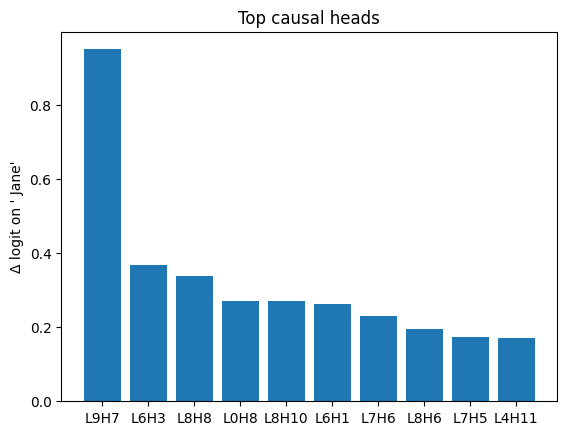

In [34]:
labels = [f"L{L}H{H}" for (L,H),_ in top]
vals   = [v for _,v in top]
plt.bar(labels, vals); plt.ylabel("Δ logit on ' Jane'"); plt.title("Top causal heads"); plt.show()


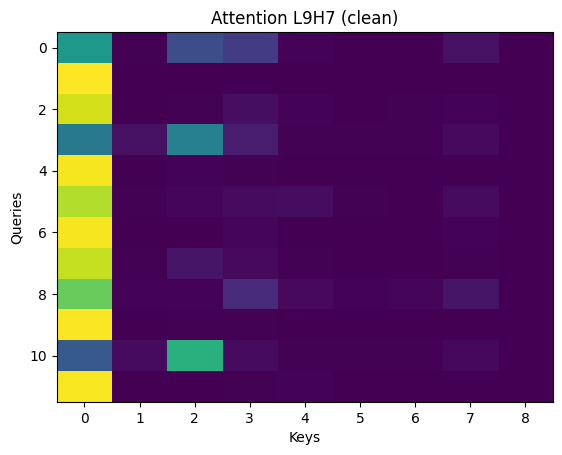

<|endoftext|>Who wrote Pride and Prejudice?


In [40]:
# get attention for the CLEAN prompt we already ran
t_clean = model.to_tokens(clean, prepend_bos=True).to(device)
_, cache_clean = model.run_with_cache(
    t_clean,
    names_filter=lambda n: ("attn.hook_pattern" in n)
)

(L0, H0), best_delta = top[0]
attn = cache_clean[f"blocks.{L0}.attn.hook_pattern"][0]  # [seq_q, n_heads, seq_k]
attn_head = attn[:, H0, :].cpu().numpy()
plt.imshow(attn_head, aspect='auto'); plt.title(f"Attention L{L0}H{H0} (clean)"); plt.xlabel("Keys"); plt.ylabel("Queries"); plt.show()
print(model.to_string(t_clean[0]))
